In [207]:
import torch
import torch.nn.functional as F
import os
import imageio
import numpy as np
import matplotlib.pyplot as plt
from models_training.utils import ResBlock

In [208]:
PATH = '/home/clement/Downloads/faces_extracted/RafDDownload-C5F6DF70564D2514B7CF6937F7F9C424/'

im_list = sorted(os.listdir(PATH))

In [209]:
tensor_imgs = []

for im in im_list:
    if 'Rafd090' in im and "frontal" in im:
        tensor_imgs.append(
            F.interpolate(
                torch.tensor(
                    np.moveaxis(
                        imageio.imread(
                            PATH + im
                            ), 2, 0
                        )
                    ).float().unsqueeze(0) / 255.,
                size=(3, 64, 64)
            )
        )   

In [210]:
all_tensors = torch.cat(tensor_imgs).reshape(-1, 8, 3, 1024, 681)
all_tensors.shape

torch.Size([67, 8, 3, 1024, 681])

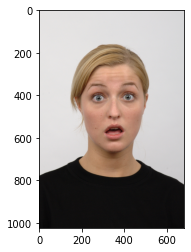

In [211]:
idx = 0
emot = 7
plt.imshow(np.moveaxis(all_tensors[idx][emot].numpy(), 0, 2))


In [212]:
all_tensors

tensor([[[[[0.8902, 0.8902, 0.8902,  ..., 0.8471, 0.8471, 0.8392],
           [0.8941, 0.8980, 0.8941,  ..., 0.8471, 0.8431, 0.8392],
           [0.8980, 0.9059, 0.8941,  ..., 0.8431, 0.8392, 0.8353],
           ...,
           [0.0353, 0.0314, 0.0353,  ..., 0.0549, 0.0549, 0.0667],
           [0.0275, 0.0353, 0.0471,  ..., 0.0510, 0.0510, 0.0471],
           [0.0314, 0.0353, 0.0510,  ..., 0.0510, 0.0588, 0.0510]],

          [[0.8941, 0.8941, 0.8863,  ..., 0.8392, 0.8471, 0.8471],
           [0.8902, 0.8941, 0.8902,  ..., 0.8471, 0.8431, 0.8471],
           [0.8941, 0.8902, 0.8902,  ..., 0.8471, 0.8431, 0.8510],
           ...,
           [0.0275, 0.0235, 0.0275,  ..., 0.0471, 0.0510, 0.0510],
           [0.0196, 0.0196, 0.0314,  ..., 0.0431, 0.0431, 0.0431],
           [0.0235, 0.0196, 0.0275,  ..., 0.0510, 0.0588, 0.0510]],

          [[0.8745, 0.8745, 0.8706,  ..., 0.8431, 0.8471, 0.8431],
           [0.8745, 0.8784, 0.8745,  ..., 0.8549, 0.8510, 0.8431],
           [0.8863, 0.8863

In [200]:
torch.save(
    all_tensors,
    "faces_front.pt"
)

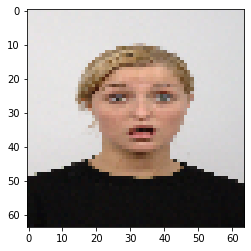

In [224]:
im_inter = F.interpolate(all_tensors[idx][emot].unsqueeze(0).unsqueeze(0), size=(3, 64, 64)).squeeze(0).squeeze(0)
plt.imshow(np.moveaxis(im_inter.numpy(), 0, 2))

In [204]:
import dataclasses
from typing import Tuple
from pythae.models.nn import BaseEncoder, BaseDecoder
from pythae.models.base.base_model import ModelOutput


@dataclasses.dataclass
class Args():
    input_dim: Tuple[int] = None
    latent_dim: int = 64


class Encoder_Faces(BaseEncoder):

    def __init__(self, args: dict):
        BaseEncoder.__init__(self)

        self.input_dim = args.input_dim
        self.latent_dim = args.latent_dim
        if hasattr(args, "context_dim"):
            self.context_dim = args.context_dim
        else:
            self.context_dim = None
        self.n_channels = args.input_dim[0]

        layers = nn.Sequential(
            nn.Conv2d(3, 16, 5, 2),
            nn.Conv2d(16, 32, 5, 2),
            nn.Conv2d(32, 64, 5, 2),
            nn.Conv2d(64, 128, 5, 2),
            nn.Conv2d(128, 128, 5, 2),
            nn.Conv2d(128, 128, 5, 2),
            ResBlock(in_channels=128, out_channels=32),
            ResBlock(in_channels=128, out_channels=32),
        )

        self.layers = layers

        self.embedding = nn.Linear(128 * 13 * 7, args.latent_dim)
        self.log_var = nn.Linear(128 * 13 * 7, args.latent_dim)
        if self.context_dim is not None:
            self.context = nn.Linear(128 * 13 * 7, self.context_dim)

    def forward(self, x: torch.Tensor):
        output = ModelOutput()

        out = self.layers(x.reshape((-1,) + self.input_dim))
        output["embedding"] = self.embedding(out.reshape(-1, 128*13*7))
        output["log_covariance"] = self.log_var(out.reshape(-1, 128*13*7))
        if self.context_dim is not None:
            output["context"] = self.context(out)

        return output

class Decoder_Faces(BaseDecoder):
    def __init__(self, args: dict):
        BaseDecoder.__init__(self)

        self.input_dim = args.input_dim
        self.latent_dim = args.latent_dim
        self.n_channels = args.input_dim[0]

        self.fc = nn.Linear(args.latent_dim, 128 * 13 * 7)

        layers = nn.Sequential(
            ResBlock(in_channels=128, out_channels=32),
            ResBlock(in_channels=128, out_channels=32),
            nn.ConvTranspose2d(128, 128, 5, 2, output_padding=(0, 1)),
            nn.ConvTranspose2d(128, 128, 5, 2, output_padding=(0, 1)),
            nn.ConvTranspose2d(128, 64, 5, 2, padding=(0, 0)),
            nn.ConvTranspose2d(64, 32, 5, 2, padding=(0, 0), output_padding=(1, 0)),
            nn.ConvTranspose2d(32, 16, 5, 2, padding=(0, 1), output_padding=(0, 1)),
            nn.ConvTranspose2d(16, 3, (4, 5), 2, padding=(0, 1)), 
        )

        self.layers = layers

    def forward(self, z: torch.Tensor):
        output = ModelOutput()

        out = self.fc(z).reshape(z.shape[0], 128, 13, 7)
        out = self.layers(out)

        output["reconstruction"] = out.reshape((z.shape[0],) + self.input_dim)

        return output

In [218]:
args = Args(input_dim=(3, 1024, 681), latent_dim=64)

encoder = Encoder_Faces(args)
decoder = Decoder_Faces(args)

In [219]:
emb = encoder(all_tensors[0][0].unsqueeze(0).float()).embedding
rec = decoder(emb).reconstruction
rec.shape

torch.Size([1, 3, 1024, 681])

In [65]:
import torch.nn as nn

conv = nn.Sequential(
    nn.Conv2d(3, 16, 5, 2),
    nn.Conv2d(16, 32, 5, 2),
    nn.Conv2d(32, 64, 5, 2),
    nn.Conv2d(64, 128, 5, 2),
    nn.Conv2d(128, 128, 5, 2),
    nn.Conv2d(128, 128, 5, 2),
    ResBlock(in_channels=128, out_channels=32),
    ResBlock(in_channels=128, out_channels=32),
)

In [66]:
conv(torch.tensor(im).unsqueeze(0).float()).shape

torch.Size([1, 128, 13, 7])

In [155]:
deconv = nn.Sequential(
    ResBlock(in_channels=128, out_channels=32),
    ResBlock(in_channels=128, out_channels=32),
    nn.ConvTranspose2d(128, 128, 5, 2, output_padding=(0, 1)),
    nn.ConvTranspose2d(128, 128, 5, 2, output_padding=(0, 1)),
    nn.ConvTranspose2d(128, 64, 5, 2, padding=(0, 0)),
    nn.ConvTranspose2d(64, 32, 5, 2, padding=(0, 0), output_padding=(1, 0)),
    nn.ConvTranspose2d(32, 16, 5, 2, padding=(0, 1), output_padding=(0, 1)),
    nn.ConvTranspose2d(16, 3, (4, 5), 2, padding=(0, 1)), 
)

In [156]:
z = torch.rand(1, 128, 13, 7)
deconv(z).shape

torch.Size([1, 3, 1024, 681])

In [43]:
1024/681*64

96.23494860499265

In [41]:
681/16

42.5625